## CSC420 Assignment 3
### Brendan Neal | 1001160236 | nealbre1

Imports and some helper functions

In [1]:
import numpy as np
from scipy import spatial
import cv2 as cv
import math

from matplotlib import pyplot as plot

# Make the plot a certain size
plot.rcParams["figure.figsize"] = [8, 6]

# Shows an image, and saves it if a filename is given
def display_image(img, file_name=None):
    
    flt_img = img.astype(float)
    img_max, img_min = np.max(flt_img), np.min(flt_img)
    
    norm_img = (((flt_img - img_min) / (img_max - img_min)) * 255).astype(np.uint8)
    
    if len(img.shape) == 2:
        plot.imshow(norm_img, cmap='gray')
    elif (len(img.shape) == 3):
        plot.imshow(cv.cvtColor(norm_img, cv.COLOR_BGR2RGB))
    plot.show()
    
    if file_name:
        cv.imwrite(file_name, norm_img)
        
def percent_difference(v1, v2):
    diff = abs(v1 - v2)
    avg = ((v1 + v2) / 2)
    return (diff / avg) * 100

#### Question 1: Door Dimension Estimation

Note: used A4 Letter Paper (8.5in x 11in = 215.9mm x 279.4mm)

Using equation from lecture 9, Page 38:

The best homography $\hat{h}$ for $n$ many matches $(x_1, y_1, x'_1, y'_1)\dots(x_n, y_n, x'_n, y'_n)$ is:

$$\hat{h} = \text{the eigenvector of } A^TA \text{ with the smallest eigenvalue}$$

Where:

$$ A = \begin{bmatrix}
x_1 & y_1 & 1 & 0   & 0   & 0       & -x'_1x_1 & -x'_1y_1 & -x'_1 \\
0   &   0 & 0 & x_1 & y_1 & 1       & -y'_1x_1 & -y'_1y_1 & -y'_1 \\
    &     &   &     &     & \vdots  &          &          &  \\
x_n & y_n & 1 & 0   & 0   & 0       & -x'_nx_n & -x'_ny_n & -x'_n \\
0   &   0 & 0 & x_n & y_n & 1       & -y'_nx_n & -y'_ny_n & -y'_n \\
\end{bmatrix}  $$

Procedure to solve this problem:

1) Determine the coordinates of the corner pixels for the paper

2) Determine the coordinates in millimeters of the paper's corners

3) Use 1, 2 to compute the homography that maps coordinates from pixels to millimeters

4) Apply the homography from 3 to the coordinates of the door's corner pixels to yield the millimeter coordinates of the door's corners

5) Use the door's millimeter corner coordinates to determine the dimensions of the door

In [2]:
def make_match_rows(x, y, x_prime, y_prime):
    """
    Makes two rows of match matrix A
    """
    return np.array([
        [x, y, 1, 0, 0, 0, -x_prime * x, -x_prime * y, -x_prime],
        [0, 0, 0, x, y, 1, -y_prime * x, -y_prime * y, -y_prime]
    ], dtype=float)

def make_match_matrix(matches):
    """
    Given an iterable of matches, where each match has the form (x, y, x_prime, y_prime),
    make the matrix A.
    """
    return np.vstack([
        make_match_rows(x, y, x_prime, y_prime) 
        for (x, y, x_prime, y_prime) in matches
    ])

def solve_homography(matches):
    """
    Given an iterable of matches, where each match has the form (x, y, x_prime, y_prime),
    compute the best homography h_hat (the eigenvector of A^TA with smallest eigenvalue).
    
    Transform this eigenvector into a 3x3 matrix
    """
    A = make_match_matrix(matches)
    eig_vals, eig_vecs = np.linalg.eig(A.transpose() @ A)
    
    # Get eigenvector with smallest eigenvalue (vectors are arranged vertically)
    homography_vec = eig_vecs[:, np.argmin(eig_vals)]
    
    # Reshape the homography into a matrix
    return homography_vec.reshape(3, 3)

def apply_homography(homography, cartesian_coords):
    """
    Applies homography to each coordinate in cartesian_coords.
    Returns an array of form [[x, y]], where (x, y) are the 
    homography-transformed cartesian coordinates.
    """
    
    # Turn the cartesian coordinates into homogeneous coordinates (columns are [x, y, 1])
    homo_coords = np.array([
        (*coord, 1) 
        for coord in cartesian_coords
    ], dtype=float).transpose()
    
    # Each column is now of form ([ax', ay', a])
    transformed = homography @ homo_coords
    
    # Divide out the a's
    normalized = transformed[:2, :] / transformed[2, :]
    
    return normalized.transpose()   

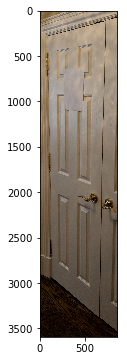

In [3]:
door_paper = cv.imread("door-paper.jpg")
display_image(door_paper)

In [4]:
# Original coordinates of paper corners (A4 Letter Paper X=215.9mm, Y=279.4mm)
paper_mm_coords = np.array([
    (0, 0), # Top Left   
    (215.9, 0), # Top Right
    (0, 279.4), # Bottom Left
    (215.9, 279.4) # Bottom Right
], dtype=float)

# Pixel coordinates of paper / door corners (used MS Paint to determine manually)
paper_pixel_coords = np.array([
    (263, 652), # Top Left
    (479, 634), # Top Right
    (263, 1089), # Bottom Left
    (472, 1111), # Bottom Right
], dtype=float)

# Solve the homography that maps pixels to mm
pixels_to_mm = solve_homography([
    (*a, *b) 
    for (a, b) in zip(paper_pixel_coords, paper_mm_coords)
])

# Pixel coordinates of door corners
door_pixel_coords = np.array([
    (87, 287), # Top Left
    (716, 122), # Top Right
    (127, 2938), # Bottom Left
    (646, 3373) # Bottom Right
], dtype=float)

# Map the door pixels into mm space
door_mm_coords = apply_homography(pixels_to_mm, door_pixel_coords)

# Figure out the width/height of the door
door_x, door_y = door_mm_coords.transpose()
door_width = max(door_x) - min(door_x)
door_height = max(door_y) - min(door_y)

# Ground truth of door dimensions (measured using tape measure)
door_width_actual = 610
door_height_actual = 2010

print("Width (mm)")
print("Estimate:     {}".format(round(door_width, 2)))
print("Actual:       {}".format(round(door_width_actual, 2)))
print("% Difference: {}".format(round(percent_difference(door_width, door_width_actual))))
print("")

print("Height (mm)")
print("Estimate:     {}".format(round(door_height, 2)))
print("Actual:       {}".format(round(door_height_actual, 2)))
print("% Difference: {}".format(round(percent_difference(door_height, door_height_actual))))

Width (mm)
Estimate:     630.38
Actual:       610
% Difference: 3.0

Height (mm)
Estimate:     2042.45
Actual:       2010
% Difference: 2.0


#### Question 2a - SIFT Matching & Visualization

Visualizing each original image:

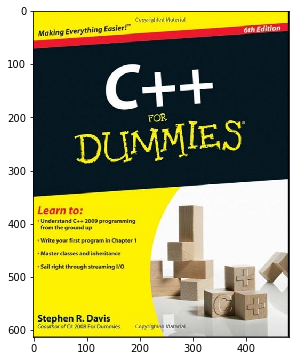

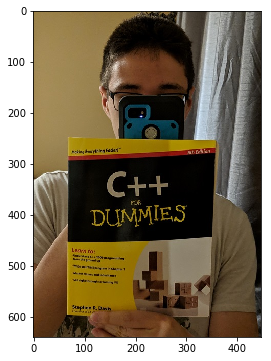

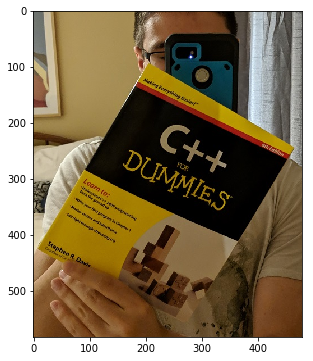

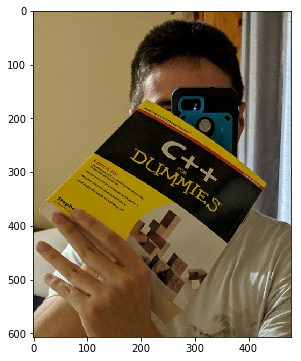

In [5]:
book_cover = cv.imread("bookCover.jpg")
im1, im2, im3 = [cv.imread("im{}.jpg".format(i)) for i in range(1, 4)]

for img in [book_cover, im1, im2, im3]:
    display_image(img)

Code to do SIFT extraction, matching and relevant visualization

In [6]:
# Copied from my A2
def extract_sift_data(img):
    sift = cv.xfeatures2d.SIFT_create(1000)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors


def match_sift_descriptors(left, right, threshold, top):
    """
    Using OpenCV's implementation of SIFT matching
    Already did this in A2, so I'm letting OpenCV do this for this assignment
    Descriptor matching algorithm not within learning scope of A3
    
    Reference code: https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    """
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(left, right, k=2)
    ret = [
        first 
        for (first, second) in matches
            if (first.distance < threshold * second.distance)
    ]
    
    return sorted(ret, key = lambda x: x.distance)[:top]

def draw_sift_keypoints(img, keypoints):
    return cv.drawKeypoints(img, keypoints, None, (0, 255, 0),  4)

def visualize_sift_matches(left_img, left_kp, right_img, right_kp, lr_matches):
    """
    Reference code: https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    """
    return cv.drawMatches(left_img, left_kp, right_img, right_kp, matches, None, flags=2, matchColor=(0, 255, 0))

Demonstrating SIFT matches between bookCover.jpg and im{1, 2, 3}.jpg

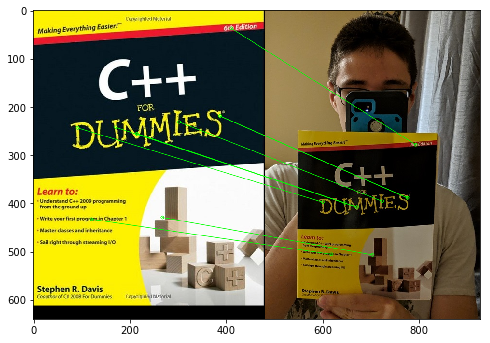

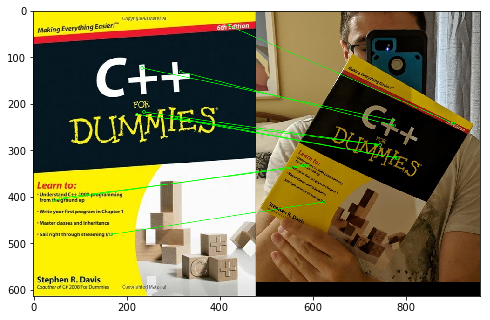

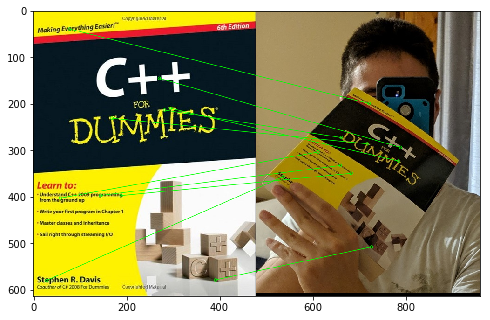

In [7]:
book_cover_kp, book_cover_desc = extract_sift_data(book_cover)

# Defining parameters for rest of question
threshold = 0.6 # Performs badly enough that outliers exist
top = 10 # So I can quickly estimate number of outliers (not too cluttered)

for x, im in enumerate([im1, im2, im3]):
    im_kp, im_desc = extract_sift_data(im) # "Left" image is im
    matches = match_sift_descriptors(book_cover_desc, im_desc, threshold, top)
    visualized = visualize_sift_matches(book_cover, book_cover_kp, im, im_kp, matches)
    display_image(visualized, "q2a-sift-match-im{}.jpg".format(x + 1))

#### Question 2b: Estimation of Outliers & RANSAC Iterations

All images have 10 data points

* *im1.jpg* - 0 outliers
    * All points seem to correspond perfectly with their counterparts

* *im2.jpg* - 1 outlier -> 10% outliers
    * Upper-left, inner corner of last "+" is mapped to upper left corner of first "+" in "C++"

* *im3.jpg* - 1 outlier -> 10% outliers
    * Top-right of 2nd "M" in "DUMMIES" mapped to bottom-left of the "D" in dummies (probably because of the lines accenting letter corners)

Recall: the minimum number of trials $S$ needed in order for RANSAC to produce a fitting model is

$$S(P, p, k) =\frac{log(1-P)}{log(1-p^k)}$$

Where:

$P$ is the probability that the trials produce a fitting model

$p$ is the proportion of inliers (number of inliers / number of points)

$k$ is the number of points used to fit the model

We have:

$P = 0.99$ (specified in instructions)

$p = 0.9$ (10% outliers means 90% inliers)

#### Number of RANSAC Iterations to Recover Affine Transform with 99% Certainty: 4

To find affine transformations we need 3 matches (6 total points, 3 pairs), $k = 3$:

$S_{aff} = S(0.99, 0.9, 3) =\frac{log(1-0.99)}{log(1-0.9^3)} = \frac{log(0.01)}{log(0.271)} = 3.527 \implies 4$ iterations

Therefore we need *4 iterations* to recover an affine transformation with 99% certainty.

#### Number of RANSAC Iterations to Recover Homography with 99% Certainty: 5

To find homographies we need 4 matches (8 total points, 4 pairs), $k = 4$

$S_{hom} = S(0.99, 0.9, 4) = \frac{log(1-0.99)}{log(1-0.9^4)} = 4.31 \implies 5$ iterations

Therefore we need *5 iterations* to recover a homography with 99% certainty.

#### Question 2c: RANSAC Affine + Visualization

Code to find the affine transformation via RANSAC.

Documentation of estimateAffine2D
https://docs.opencv.org/3.3.1/d9/d0c/group__calib3d.html#ga27865b1d26bac9ce91efaee83e94d4dd

Calls the OpenCV function estimateAffine2D with the following parameters (explanations below each):

* from / to = array of 2D points in left_kp and right_kp, respectively
    * Want to find affine transformation that maps left keypoints to right keypoints
    
    
* method = cv.RANSAC
    * Want to use RANSAC implementation of algorithm
    
    
* ransacReprojThreshold = 3
    * Pixel distance threshold to judge the accuracy of proposed affine matrices. Matrices are evaluated as follows:
        * Select all other points that were NOT used to fit the affine matrix
        * Determine the new mapping of these points when the affine matrix is applied
        * Compare these mappings against the ground-truth
        * If the distance between a mapping and the ground-truth is greater than the threshold, this counts as a mistake
        * The fewer mistakes the proposed matrix makes, the better it is
        
        
* maxIters = ransac_iterations(confidence, inliers, samples = 3)
    * Determines how many iterations RANSAC can run
    * confidence and inliers are given by caller
    * Need to pick 3 points to determine affine matrix.
          
          
* confidence = 0.99
    * OpenCV default


* refineIters = 0
    * Circumvent OpenCV from running refinement procedure on generated matrix
    
The function generates a tuple, the first element of this tuple is the best-fitting affine matrix.
    
High-level explanation of OpenCV's affine RANSAC algorithm:

1. Pick 3 points and find an affine transformation that fits them

2. Judge the accuracy of this transformation against all other UNPICKED points

    i. Feed each point through the affine transform to get the proposed location
    
    ii. Measure the distance between the proposed location and the ground-truth (euclidean)
    
    iii. If this distance exceeds the ransacReprojThreshold, count it as a mistake (outlier WRT proposed matrix)
    
    iv. Tally up all the mistakes made by the affine transform

3. Compare the mistakes made by proposed affine transform against the best transform so far.

4. If the number of mistakes is a new all-time low, replace the best affine transform with the current transform

5. Repeat steps 1 to 4 for specified number of iterations. Return the best affine matrix.

In [8]:
def keypoints_to_coords(keypoints):
    """
    Converts keypoints into a numpy array of form [[x, y]]
    """
    return np.array([kp.pt for kp in keypoints])

def ransac_iterations(confidence, inliers, samples):
    """
    Computes the number of iterations needed for RANSAC to 
    recover an inlier-fitting model with confidence %
    """
    flt = math.log(1 - confidence) / math.log(1 - (inliers ** samples))
    return int(math.ceil(flt))
    

def ransac_affine(left_kp, right_kp, lr_matches, confidence, inliers):
    """
    Uses RANSAC to find the affine transform that maps points from left to right.
    """
    
    # Find the indexes of the keypoints
    left_inds = np.array([x.queryIdx for x in lr_matches])
    right_inds = np.array([x.trainIdx for x in lr_matches])
    
    # Turn the keypoints into coordinate arrays of form [[x, y]]
    left_coords = keypoints_to_coords(left_kp)[left_inds]
    right_coords = keypoints_to_coords(right_kp)[right_inds]
    
    # Determine number of iterations for 3 samples
    iters = ransac_iterations(confidence, inliers, 3)
    
    # Return the first element (the matrix)
    return cv.estimateAffine2D(left_coords, right_coords,
                               method=cv.RANSAC, 
                               maxIters=iters,
                               refineIters=0)[0]

def affine_paste(lr_affine, left_img, right_img):
    """
    Pastes left_img onto right_img (after warping left_img with lr_affine)
    
    Warping Reference Code: https://www.learnopencv.com/homography-examples-using-opencv-python-c/
    """
    
    # Warp the left image
    left_warped = cv.warpAffine(left_img,
                                M=lr_affine, 
                                dsize=(right_img.shape[1], right_img.shape[0]))
    
    # Put the warp on top of right
    ret = np.copy(right_img)
    ret[left_warped > 0] = left_warped[left_warped > 0]
    
    return ret

Finding and visualizing the affine transformations that map bookCover.jpg to im{1, 2, 3}.jpg.

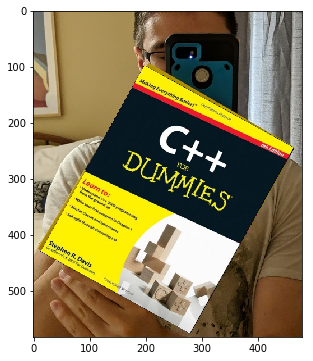

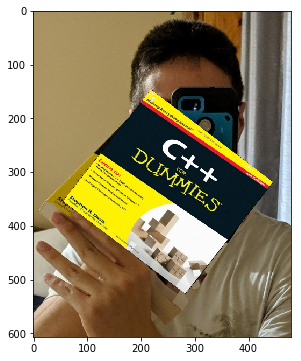

In [9]:
for x, im in enumerate([im1, im2, im3]):
    im_kp, im_desc = extract_sift_data(im)
    
    matches = match_sift_descriptors(book_cover_desc, im_desc, threshold, top)
    affine = ransac_affine(book_cover_kp, im_kp, matches, confidence = 0.99, inliers = 0.9)
    pasted = affine_paste(affine, book_cover, im)
    
    display_image(pasted, "q2c-bookCover-im{}.jpg".format(x + 1))

Overall, the affine transform performed almost perfectly for im1 and im2, but more poorly for im3. This is because the affine transform is able to represent rotation and scaling, but not perspective changes. 

Both im1 and im2 represent scaling and rotation changes, with very little change in perspective. Therefore, they can be represented well with an affine transform. However, the book in im2 does have some perspective change (it is tilted very slightly towards the camera), so this explains why the transform is not perfect.


im3 includes both a scaling, rotation and perspective change as the book is tilted backwards and rotated. Therefore, an affine transform cannot be expected to work as well as it now has to deal with perspective. As seen in the image, the bottom corners of the re-mapped cover do not match up with the original corners. This is because the bottom width of the re-mapped cover is the same as the top width of the re-mapped cover. The original cover's top width was slightly smaller than its bottom width due to the perspective change - the top of the book is further away when tilted backwards.

Of course, the technique is sensitive to wrongly-mapped points (outliers). These will destroy the quality of the affine transform. This affine transform now has to minimize error in the face of contradictory mappings, and therefore does not perform well. Consider what happens when we allow outliers to take part in determining the affine transform in im3:

In [10]:
# Affine transformation solving code copied from my A2
def affine_left_matrix(coords):
    """
    Input: array of form [[x, y]]
    Returns a 2D array of form
    [
        ...
        [x, y, 0, 0, 1, 0]
        [0, 0, x, y, 0, 1]
        ...
    ]
    """
    
    # Need to have 6 columns, and twice as many rows
    ret_dims = (coords.shape[0] * 2, 6)
    ret = np.empty(ret_dims, coords.dtype)
    
    # Use numpy indexing
    i = np.arange(coords.shape[0])
    
    # Even Rows: [x, y, 0, 0, 1, 0]
    ret[2*i, :2] = coords[i]
    ret[2*i, 2:] = [0, 0, 1, 0]
    
    # Odd Rows: [0, 0, x, y, 0, 1]
    ret[2*i + 1, :2] = [0, 0]
    ret[2*i + 1, 2:4] = coords[i]
    ret[2*i + 1, 4:] = [0, 1]
    
    return ret

def affine_right_matrix(coords):
    """
    Returns a 2D array of form 
    [
        [x]
        [y]
        ...
    ]
    """
    
    # Return array needs to be twice as long
    ret = np.empty(coords.shape[0] * 2, dtype = coords.dtype)
    
    # Use numpy indexing
    i = np.arange(coords.shape[0])
    
    # Even Rows = x
    ret[2*i] = coords[i, 0]
    
    # Odd Rows = y 
    ret[2*i + 1] = coords[i, 1]
    
    return ret
    
    
def naive_affine(left_kp, right_kp, lr_matches):
    
    # Find the indexes of the keypoints
    left_inds = np.array([x.queryIdx for x in lr_matches])
    right_inds = np.array([x.trainIdx for x in lr_matches])
    
    # Turn the keypoints into coordinate arrays of form [[x, y]]
    left_coords = keypoints_to_coords(left_kp)[left_inds]
    right_coords = keypoints_to_coords(right_kp)[right_inds]
    
    # Using equation from lecture 8B: PA = P' -> A = P_inv * P'
    P = affine_left_matrix(left_coords)
    P_prime = affine_right_matrix(right_coords)
    
    # Compute inverse using moore-penrose pseudo inverse
    P_inv = np.linalg.pinv(P)
    
    # Approximation of affine transformation vector (a, b, c, d, e, f)
    (a, b, c, d, e, f) = np.matmul(P_inv, P_prime).flatten()
    
    # The affine transformation matrix
    return np.array(
        [[a, b, e],
         [c, d, f]]
    )
    


im3_kp, im3_desc = extract_sift_data(im3)
matches = match_sift_descriptors(book_cover_desc, im3_desc, threshold, top)
affine = naive_affine(book_cover_kp, im3_kp, matches)
pasted = affine_paste(affine, book_cover, im3)
display_image(pasted, "q2c-outlier-bookCover-im3.jpg".format(x + 2))

#### Question 2d: Using Homography to find transformation

Code to find homography of SIFT matches via RANSAC. 

This calls the OpenCV function findHomography using the RANSAC implementation.

Documentation: https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findhomography

This algorithm obeys an almost identical high-level procedure as the estimateAffine2D function in question 2c. Each algorithm differs in how they propose their models:
* estimateAffine2D picks 3 matches to propose an affine transformation matrix.
* findHomography picks 4 matches to compute a homography matrix.

It should be noted that findHomography refines the best homography matrix after it has found by RANSAC. 

However, the function also returns a binary mask that identifies the original inliers to the best raw homography matrix. 

This will be used in combination with the homography-solver from question 1 to retrieve the best UNREFINED homography matrix.

In [11]:
def ransac_homography(left_kp, right_kp, lr_matches, confidence, inliers):
    """
    Uses RANSAC to find the affine transform that maps points from left to right
    """
    
    # Find the indexes of the keypoints
    left_inds = np.array([x.queryIdx for x in lr_matches])
    right_inds = np.array([x.trainIdx for x in lr_matches])
    
    # Turn the keypoints into coordinate arrays of form [[x, y]]
    left_coords = keypoints_to_coords(left_kp)[left_inds]
    right_coords = keypoints_to_coords(right_kp)[right_inds]
    
    # Determine number of iterations for 4 samples
    iters = ransac_iterations(confidence, inliers, 4)
    
    # Determine indices of inliers to original best matrix
    inlier_mask = cv.findHomography(left_coords, right_coords,
                             method=cv.RANSAC, 
                             maxIters=iters)[1].flatten()
    inlier_inds = np.nonzero(inlier_mask)
    
    # Narrow points down to inliers
    left_inliers, right_inliers = left_coords[inlier_inds], right_coords[inlier_inds]
    
    # Solve the homography
    return solve_homography([
        (*a, *b) 
        for (a, b) in zip(left_inliers, right_inliers)
    ])

    

def homography_paste(lr_homography, left_img, right_img):
    """
    Warping Reference Code: https://www.learnopencv.com/homography-examples-using-opencv-python-c/
    """
    
    # Warp the left image
    left_warped = cv.warpPerspective(left_img, homography, (right_img.shape[1], right_img.shape[0]))
    
    # Put the warp on top of right
    ret = np.copy(right_img)
    ret[left_warped > 0] = left_warped[left_warped > 0]
    
    return ret

Finding and visualizing the homographies that map bookCover.jpg to im{1, 2, 3}.jpg.

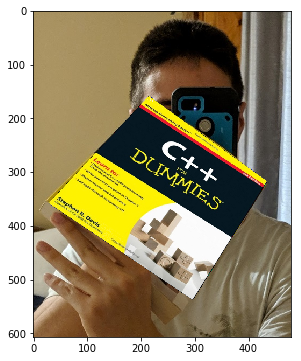

In [12]:
for x, im in enumerate([im1, im2, im3]):
    im_kp, im_desc = extract_sift_data(im)
    
    matches = match_sift_descriptors(book_cover_desc, im_desc, threshold, top)
    homography =  ransac_homography(book_cover_kp, im_kp, matches, confidence = 0.99, inliers = 0.9)
    pasted = homography_paste(homography, book_cover, im)
    
    display_image(pasted, "q2d-bookCover-im{}.jpg".format(x + 1))

Overall, the homography performed almost perfectly for im2 and im3, but more poorly for im1. For im2 and im3, the homography was able to account for the perspective changes in both im2 and im3. For im1, the homography might have been trying to account for "perceived" changes in perspective, rather than actual changes in perspective.

As with the affine transform, homography is also sensitive to wrongly-mapped points (outliers). Again, these will destroy the quality of transform as it has to minimize error in the face of contradictory mappings.

Consider what happens when we allow outliers to take part in determining the affine transform for im2 and im3, which both have outliers (discussed previously):

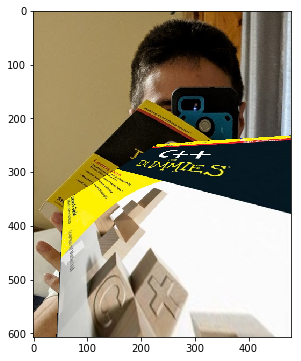

In [13]:
def naive_homography(left_kp, right_kp, lr_matches):
    # Find the indexes of the keypoints
    left_inds = np.array([x.queryIdx for x in lr_matches])
    right_inds = np.array([x.trainIdx for x in lr_matches])
    
    # Turn the keypoints into coordinate arrays of form [[x, y]]
    left_coords = keypoints_to_coords(left_kp)[left_inds]
    right_coords = keypoints_to_coords(right_kp)[right_inds]
    
    return solve_homography([
        (*a, *b) 
        for (a, b) in zip(left_coords, right_coords)
    ])

for x, im in enumerate([im2, im3]):
    im_kp, im_desc = extract_sift_data(im)
    
    matches = match_sift_descriptors(book_cover_desc, im_desc, threshold, top)
    homography =  naive_homography(book_cover_kp, im_kp, matches)
    pasted = homography_paste(homography, book_cover, im)
    
    display_image(pasted, "q2d-outier-bookCover-im{}.jpg".format(x + 2))

#### Question 2e : Image Editing via Homography

Pasting anotherBookCover.jpg onto im{1, 2, 3}.jpg.

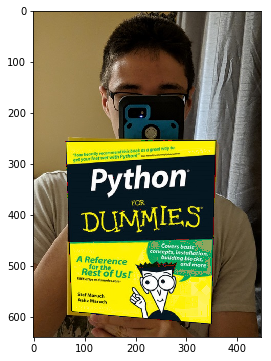

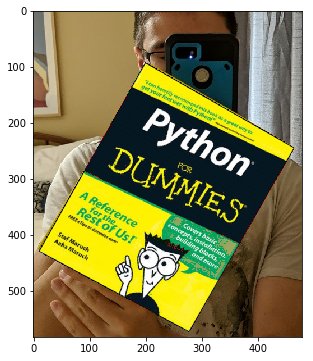

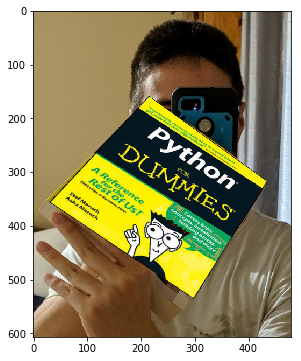

In [14]:
another_cover = cv.imread("anotherBookCover.jpg")
display_image(another_cover)

for x, im in enumerate([im1, im2, im3]):
    im_kp, im_desc = extract_sift_data(im)
    
    matches = match_sift_descriptors(book_cover_desc, im_desc, threshold, top)
    homography = ransac_homography(book_cover_kp, im_kp, matches, confidence = 0.99, inliers = 0.9)
    pasted = homography_paste(homography, another_cover, im)
    
    display_image(pasted, "q2e-anotherBookCover-im{}.jpg".format(x + 1))

Overall, the results are fairly good and are on par with their counterpart results in 2d. This should be expected as the new cover is almost the same dimensions as the original cover. Therefore, the homography should map the new cover onto the old cover nearly as well as the respective re-mapping in 2d.